# 0. 라이브러리 임포트

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
import os
from keras.preprocessing.image import ImageDataGenerator

# 1. 데이터 가져오기

In [38]:
data_dir = r'C:/Users/isfs0/Intel_AI Process/AI-20231012/AI4FW023/chest_xray' # 저장 디렉토리 지정

train_datagen = ImageDataGenerator(rescale=1.0/255) # train data 정규화
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'), # C:/Users/isfs0/Intel_AI Process/AI-20231012/AI4FW023/chest_xray/train
    target_size=(224, 224), # resize (계산 성능 상향)
    batch_size=32, # 한 번에 처리되는 이미지의 개수 : 32
    class_mode='binary',
    color_mode='grayscale',  # 회색조로 변경
    shuffle=True # shuffle은 데이터를 섞을지 여부를 나타내며, True로 설정되었으므로 데이터가 에포크마다 섞임
    # 모델이 데이터의 순서에 의존하지 않도록 하며, 다양한 예제로 학습할 수 있도록 도와줍
)

val_datagen = ImageDataGenerator(rescale=1.0/255) # val data 정규화
val_generator = val_datagen.flow_from_directory(
    os.path.join(data_dir, 'val'), # C:/Users/isfs0/Intel_AI Process/AI-20231012/AI4FW023/chest_xray/val
    target_size=(224, 224), # resize (계산 성능 상향)
    batch_size=32, # 한 번에 처리되는 이미지의 개수 : 32
    class_mode='binary',
    color_mode='grayscale',  # 회색조로 변경
    shuffle=False
    # 검증 데이터는 모델의 성능을 평가하기 위한 데이터
    # 일반적으로 한 번에 모델에 공급되고 순서대로 처리됩니다. 
    # 데이터를 무작위로 섞으면 모델의 성능을 정확하게 평가하기 어려워질 수 있음 따라서 False
)

test_datagen = ImageDataGenerator(rescale=1.0/255) # test data 정규화
test_generator = test_datagen.flow_from_directory(
    os.path.join(data_dir, 'test'), # C:/Users/isfs0/Intel_AI Process/AI-20231012/AI4FW023/chest_xray/test
    target_size=(224, 224), # resize (계산 성능 상향)
    batch_size=32, # 한 번에 처리되는 이미지의 개수 : 32
    class_mode='binary',
    color_mode='grayscale',  # 회색조로 변경
    shuffle=False
    # 테스트 데이터는 모델의 성능을 평가하기 위한 데이터 
    # 일반적으로 한 번에 모델에 공급되고 순서대로 처리됩니다. 
    # 데이터를 무작위로 섞으면 모델의 성능을 정확하게 평가하기 어려워질 수 있음 따라서 False
)

# 데이터의 예측값이 0 : 폐렴환자 / 1: 정상인 이므로, 이진분류 모델 이용 -> class_mode='binary',

Found 5210 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# 2. 데이터 살펴보기

Train Data Shape: (32, 224, 224, 1)
Validation Data Shape: (16, 224, 224, 1)
Test Data Shape: (32, 224, 224, 1)


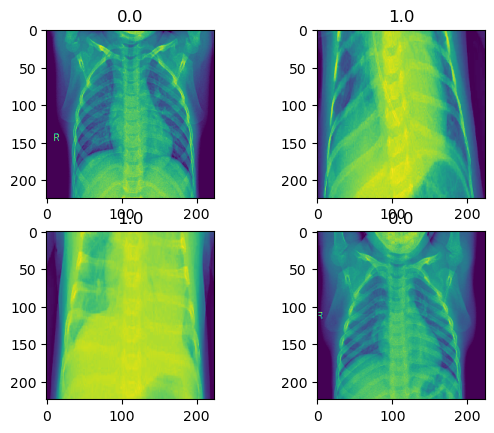

In [39]:
print("Train Data Shape:", train_generator[0][0].shape)
print("Validation Data Shape:", val_generator[0][0].shape)
print("Test Data Shape:", test_generator[0][0].shape)

# 이미지 확인 (첫 번째 배치의 이미지 4개 출력)
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(train_generator[0][0][i])
    plt.title(train_generator[0][1][i])
plt.show()

# 3. 데이터 정규화

In [35]:
# 데이터 전처리 과정에서 정규화 완료
# train_datagen = ImageDataGenerator(rescale=1.0/255)
# val_datagen = ImageDataGenerator(rescale=1.0/255)
# test_datagen = ImageDataGenerator(rescale=1.0/255)

# (rescale=1.0/255)의 의미


1. 이미지의 픽셀 값은 일반적으로 0부터 255까지의 범위에 있음.
2. 이 범위는 다양한 이미지 포맷 (예: JPEG)에서 사용됨
3. 딥러닝 모델을 훈련할 때, 입력 데이터를 특정 범위로 정규화하는 것이 중요
4. 일반적으로 0에서 1 사이의 범위로 스케일을 조정하거나 -1에서 1 사이의 범위로 스케일을 조정
5. 1.0/255를 사용하면 원래의 0에서 255 범위의 픽셀 값을 0에서 1 범위로 조정합니다. 
6. 즉, 각 픽셀 값을 255로 나누어 0에서 1로 정규화 처리

# 5. 모델 구성 및 컴파일 및 학습

In [40]:
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), input_shape=(224, 224, 1), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# 옵티마이저'adam'' - adam의 경우 모멘텀+RMSprop을 합친 최적의 성능을 나타내는 최적화방법
# 이진분류(폐렴양성, 폐렴음성)이므로, 손실함수를 최소화 하기 위해 binary_crossentropy
## 다중분류의 손실 최소화 기법은 categorical-crossentropy, sparse_cg_categoricalentropy 둘의 차이점은 원핫인코딩 여부
# 평가지표는 accuracy. 필요에 따라 Precision, Recall, F1 score, 경우에따라 specification 나타낼 수 있음
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# model.fit 함수를 사용하여 모델을 훈련하고 훈련 과정의 성능 및 손실을 기록한 history 객체를 반환
history = model.fit(train_generator, validation_data=val_generator, epochs=10) 
# 이렇게 기록된 히스토리 정보를 사용하여 모델의 훈련 진행 상황을 시각화하거나 평가


Epoch 1/10
163/163 [==============================] - 622s 4s/step - loss: 0.3073 - accuracy: 0.8683 - val_loss: 0.6471 - val_accuracy: 0.6875
Epoch 2/10
163/163 [==============================] - 613s 4s/step - loss: 0.1391 - accuracy: 0.9486 - val_loss: 0.3718 - val_accuracy: 0.8125
Epoch 3/10
163/163 [==============================] - 1029s 4s/step - loss: 0.1142 - accuracy: 0.9616 - val_loss: 0.2035 - val_accuracy: 0.9375
Epoch 4/10
163/163 [==============================] - 611s 4s/step - loss: 0.1065 - accuracy: 0.9637 - val_loss: 0.1773 - val_accuracy: 0.8750
Epoch 5/10
163/163 [==============================] - 1325s 8s/step - loss: 0.0835 - accuracy: 0.9695 - val_loss: 0.5796 - val_accuracy: 0.8125
Epoch 6/10
163/163 [==============================] - 610s 4s/step - loss: 0.0723 - accuracy: 0.9770 - val_loss: 0.1288 - val_accuracy: 0.8750
Epoch 7/10
163/163 [==============================] - 132s 808ms/step - loss: 0.0578 - accuracy: 0.9816 - val_loss: 0.2220 - val_accuracy: 0

# 6. 모델 평가

In [41]:
test_loss, test_accuracy = model.evaluate(test_generator) # test data의 손실율과 정확도 확인
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

20/20 [==============================] - 13s 630ms/step - loss: 1.7395 - accuracy: 0.7772
Test Loss: 1.7394771575927734
Test Accuracy: 0.7772436141967773


# 7. 모델 훈련 분석

Text(0.5, 1.0, 'Training & Validation Loss')

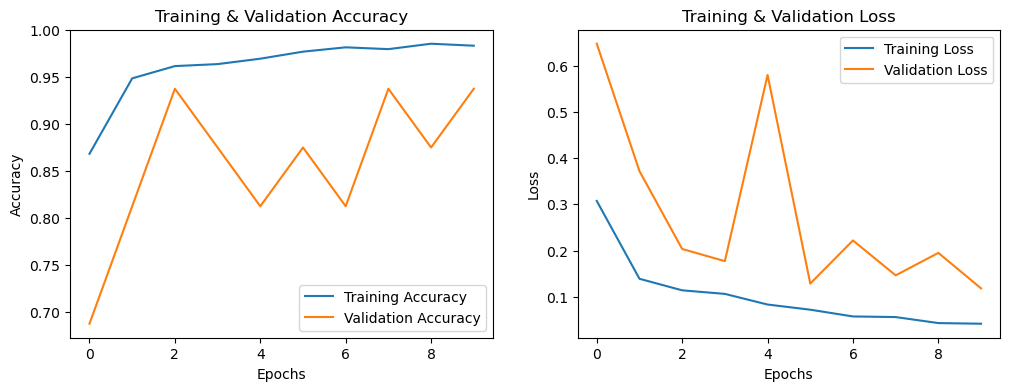

In [42]:
plt.figure(figsize=(12, 4)) # 가로크기 12, 세로크기 4
plt.subplot(1, 2, 1) # (행, 열, 왼쪽)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2) # (행, 열, 오른쪽)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

# 8. 모델 예측

In [43]:
y_pred = model.predict(test_generator)
y_pred = (y_pred > 0.5) # 이진분류 모델이므로 클래스는 0,1 로 분류. 따라서 0.5 보다 클때에는 양성(폐렴진단), 작을 때에는 음성(정상)

# 9. Confusion Matrix 및 Classification Report 출력

In [44]:
test_labels = test_generator.classes
cm = confusion_matrix(test_labels, y_pred)
print("Confusion Matrix:")
print(cm)

print("Classification Report:")
print(classification_report(test_labels, y_pred))

# cm = confusion matrix
# Confusion Matrix:
# True Positive (TP, 진양성): 실제 양성 클래스(1)인데 모델이 정확하게 양성 클래스로 예측한 케이스 수. 이 경우에는 387
# False Positive (FP, 가양성): 실제 음성 클래스(0)인데 모델이 잘못하여 양성 클래스로 예측한 케이스 수. 이 경우에는 136
# True Negative (TN, 진음성): 실제 음성 클래스(0)인데 모델이 정확하게 음성 클래스로 예측한 케이스 수. 이 경우에는 98
# False Negative (FN, 가음성): 실제 양성 클래스(1)인데 모델이 잘못하여 음성 클래스로 예측한 케이스 수. 이 경우에는 3
# Accuracy(정확도) = (TP + TN) / (TP + TN + FP + FN) = 387+80 / 624 = 74.83% - 0.75
# Precision(정밀도) = TP / (TP + FP) = 387 / 387 + 154 = 71.53% - 0.72
# Recall(재현율, 민감도) = TP / (TP + FN) = 387 / 387+3 = 99.23%  - 0.99
# F1 Score = Presion 과 Recall의 조화평균 = 2 * (Precision*Recall) / Precision + Recall = 0.83
# speicificity(특이도) = TN / (TN+FP) = 0.34
# ROC Curve = 1 - 특이도 = 0.66 1 - TN / (TN + FP) = FP / (TN+FP) = FPR(위양성율)

Confusion Matrix:
[[ 98 136]
 [  3 387]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.42      0.59       234
           1       0.74      0.99      0.85       390

    accuracy                           0.78       624
   macro avg       0.86      0.71      0.72       624
weighted avg       0.83      0.78      0.75       624



# 10. 올바르게 예측된 클래스와 잘못 예측된 클래스 샘플 6개씩 plt.show

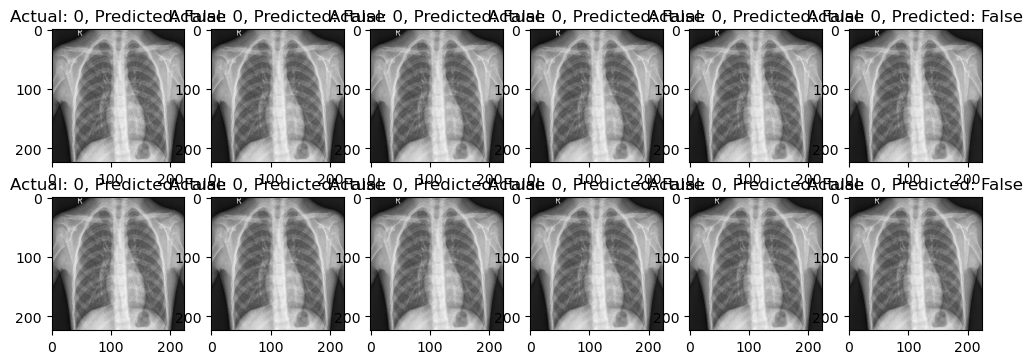

In [45]:
# indices = index의 복수형
correctly_predicted_indices = np.where(y_pred == test_labels)[0] # 정확하게 예측된 이미지의 인덱스를 추출
incorrectly_predicted_indices = np.where(y_pred != test_labels)[0] # 잘못 예측된 이미지의 인덱스를 추출

plt.figure(figsize=(12, 4)) # 가로 12, 세로 4

# Correctly Predicted Images
for i, idx in enumerate(correctly_predicted_indices[:6]): # 인덱스 0번부터 5번까지 반복
    plt.subplot(2, 6, i + 1) # 2행 6열 첫번째부터 +1씩 나열 
    image = test_generator[idx][0][0]  
    # image 는 test_generator 로부터 [0]은 첫 번째 배치를 선택하고, [0]은 해당 배치에서 첫 번째 이미지를 선택
    
    plt.imshow(image, cmap='gray')  # 컬러맵(colormap)을 gray'로 설정
    plt.title(f'Actual: {test_labels[idx]}, Predicted: {y_pred[idx][0]}')

# Incorrectly Predicted Images
for i, idx in enumerate(incorrectly_predicted_indices[:6]): # 인덱스 0번부터 5번까지 반복
    plt.subplot(2, 6, i + 7) # 2행 6열 일곱번째부터 +1씩 나열 
    image = test_generator[idx][0][0]
    # image 는 test_generator 로부터 [0]은 첫 번째 배치를 선택하고, [0]은 해당 배치에서 첫 번째 이미지를 선택
    
    plt.imshow(image, cmap='gray')  # 컬러맵(colormap)을 gray'로 설정
    plt.title(f'Actual: {test_labels[idx]}, Predicted: {y_pred[idx][0]}') 

plt.show()